In [1]:
# 1) Setup
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="talk", style="whitegrid")

logs_dir = Path("/Users/chrible/work/projects/conference-simulation/simulation/reputation-environment/log")
jsonl_path = logs_dir / "stats.jsonl"
final_summary_path = logs_dir / "final_summary.json"

In [2]:
# 2) Load JSONL (one snapshot per step) and flatten
rows = []
with open(jsonl_path) as f:
    for line in f:
        line = line.strip()
        if line:
            rows.append(json.loads(line))

df = pd.json_normalize(rows, sep=".")
df.rename(columns={"steps": "step"}, inplace=True)
df.sort_values("step", inplace=True, ignore_index=True)

# Per-step deltas (derived)
df["effort_delta"] = df["total_effort"].diff().fillna(df["total_effort"]).clip(lower=0)
df["reward_delta"] = df["total_rewards_distributed"].diff().fillna(df["total_rewards_distributed"]).clip(lower=0)
df["new_finished"] = df["finished_projects"].diff().fillna(df["finished_projects"]).clip(lower=0)

# Optional smoothing
df["effort_delta_ma"] = df["effort_delta"].rolling(10, min_periods=1).mean()
df["reward_delta_ma"] = df["reward_delta"].rolling(10, min_periods=1).mean()

df.head(3)

,step,total_effort,avg_effort_per_step,finished_projects,successful_projects,unsuccessful_projects,success_rate,avg_effort_per_finished_project,avg_effort_successful_projects,avg_effort_unsuccessful_projects,...,observation_aggregates.project_team_sizes.project_4847-4-999,observation_aggregates.project_team_sizes.project_4848-0-1000,observation_aggregates.project_team_sizes.project_4849-4-1000,observation_aggregates.project_team_sizes.project_4850-4-1000,observation_aggregates.project_team_sizes.project_4851-5-1000,effort_delta,reward_delta,new_finished,effort_delta_ma,reward_delta_ma
0,1,0.000000,0.000000,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.000000,0.0
1,2,14.546559,7.273279,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,14.546559,0.0,0.0,7.273279,0.0
2,3,42.743102,14.247701,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,28.196543,0.0,0.0,14.247701,0.0


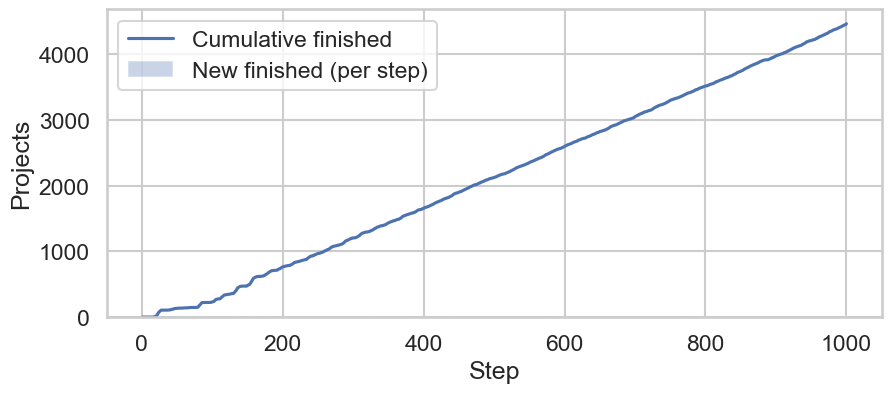

In [3]:
# 3) Finished projects over time
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["step"], df["finished_projects"], label="Cumulative finished")
ax.bar(df["step"], df["new_finished"], alpha=0.3, label="New finished (per step)")
ax.set_xlabel("Step")
ax.set_ylabel("Projects")
ax.legend()
plt.show()

In [4]:
# Load last step's project team sizes
last = None
with open(jsonl_path) as f:
    for line in f:
        if line.strip():
            last = json.loads(line)

team_sizes = last["observation_aggregates"]["project_team_sizes"]  # dict of {proj_id: size}


In [5]:
# Build a long dataframe of team sizes over time for plotting
for rec in rows:
    step = rec["steps"]
    ts_map = rec.get("observation_aggregates", {}).get("project_team_sizes", {})
    for proj_id, size in ts_map.items():
        rec.update({"step": step, "project_id": proj_id, "team_size": size})

df_team = pd.DataFrame(rows).sort_values(["project_id", "step"])
df_team.head()

,steps,total_effort,avg_effort_per_step,finished_projects,successful_projects,unsuccessful_projects,success_rate,avg_effort_per_finished_project,avg_effort_successful_projects,avg_effort_unsuccessful_projects,avg_finished_project_duration,avg_finished_project_team_size,total_rewards_distributed,avg_reward_per_step,per_agent_total_effort,observation_aggregates,step,project_id,team_size
161,162,5266.629104,32.510056,610,61,549,0.100000,6.662181,13.525161,5.899628,72.813115,1.062295,31.869374,0.196725,"{'agent_0': 90.50000000000006, 'agent_1': 38.4...","{'avg_age': 162.0, 'avg_accumulated_rewards': ...",162,project_1004-4-162,1
162,163,5294.238043,32.479988,614,62,552,0.100977,6.663405,13.379594,5.909050,72.760586,1.061889,32.153073,0.197258,"{'agent_0': 90.60000000000005, 'agent_1': 38.4...","{'avg_age': 163.0, 'avg_accumulated_rewards': ...",163,project_1008-0-163,1
163,164,5320.763157,32.443678,617,63,554,0.102107,6.666014,13.281505,5.913710,72.790924,1.061588,33.313623,0.203132,"{'agent_0': 90.60000000000005, 'agent_1': 38.5...","{'avg_age': 164.0, 'avg_accumulated_rewards': ...",164,project_1013-2-164,1
164,165,5346.302095,32.401831,618,63,555,0.101942,6.656198,13.281505,5.904136,72.800971,1.061489,33.313623,0.201901,"{'agent_0': 90.60000000000005, 'agent_1': 38.6...","{'avg_age': 165.0, 'avg_accumulated_rewards': ...",165,project_1016-4-165,1
165,166,5378.565541,32.400997,619,63,556,0.101777,6.651261,13.281505,5.899992,72.718901,1.061389,33.313623,0.200684,"{'agent_0': 91.50000000000006, 'agent_1': 38.7...","{'avg_age': 166.0, 'avg_accumulated_rewards': ...",166,project_1017-4-166,1


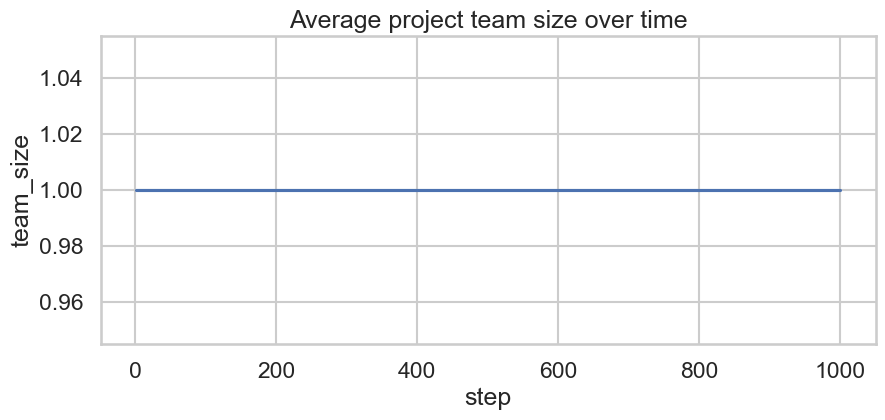

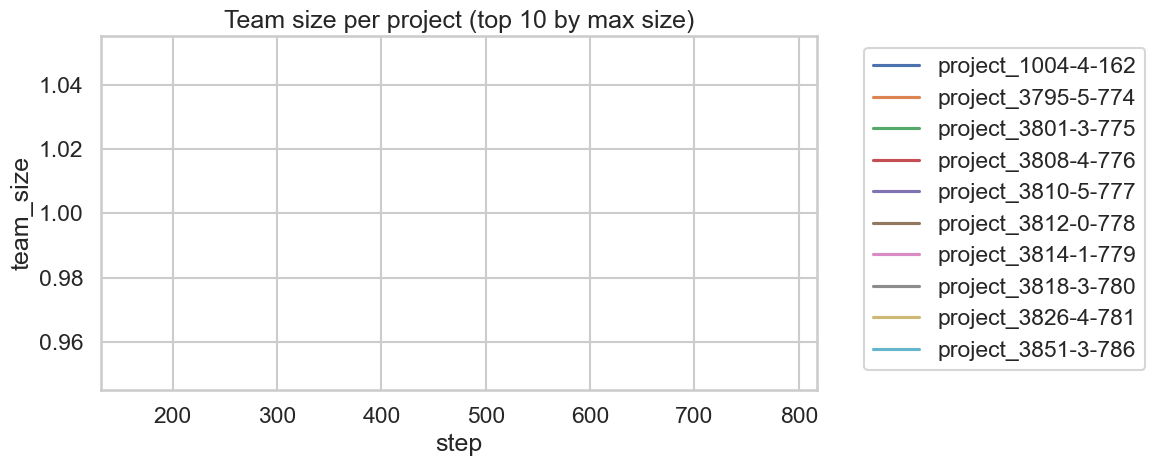

In [6]:
# 1) Team size distribution per step
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df_team, x="step", y="team_size", estimator="mean", errorbar="sd", ax=ax)
ax.set_title("Average project team size over time")
plt.show()

# 2) Team sizes per project (top projects by max team size)
top_projects = (
    df_team.groupby("project_id")["team_size"].max().sort_values(ascending=False).head(10).index
)
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df_team[df_team["project_id"].isin(top_projects)], x="step", y="team_size", hue="project_id", ax=ax)
ax.set_title("Team size per project (top 10 by max size)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

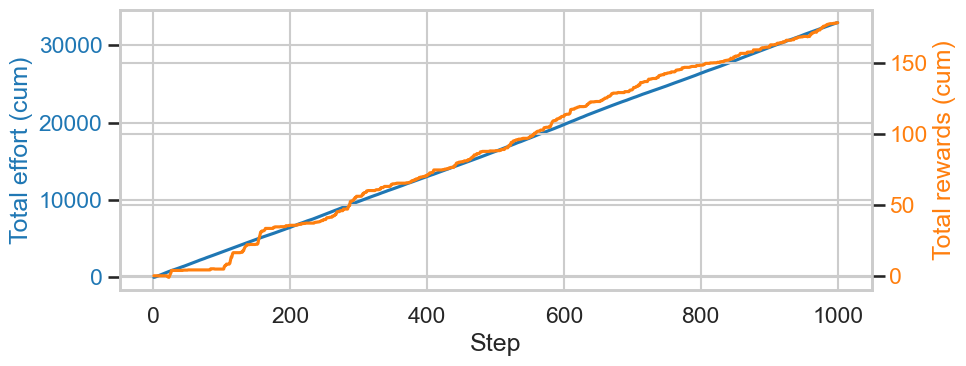

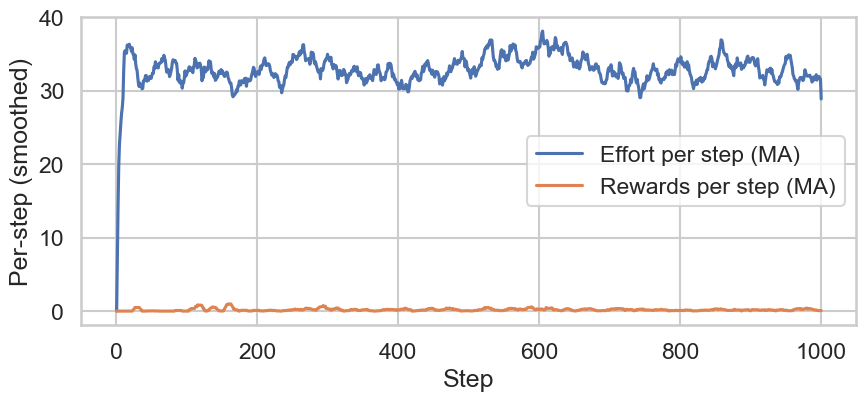

In [7]:
# 4) Effort and rewards (cumulative and per-step)
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(df["step"], df["total_effort"], color="tab:blue", label="Total effort (cum)")
ax1.set_xlabel("Step")
ax1.set_ylabel("Total effort (cum)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(df["step"], df["total_rewards_distributed"], color="tab:orange", label="Total rewards (cum)")
ax2.set_ylabel("Total rewards (cum)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["step"], df["effort_delta_ma"], label="Effort per step (MA)")
ax.plot(df["step"], df["reward_delta_ma"], label="Rewards per step (MA)")
ax.set_xlabel("Step"); ax.set_ylabel("Per-step (smoothed)")
ax.legend()
plt.show()

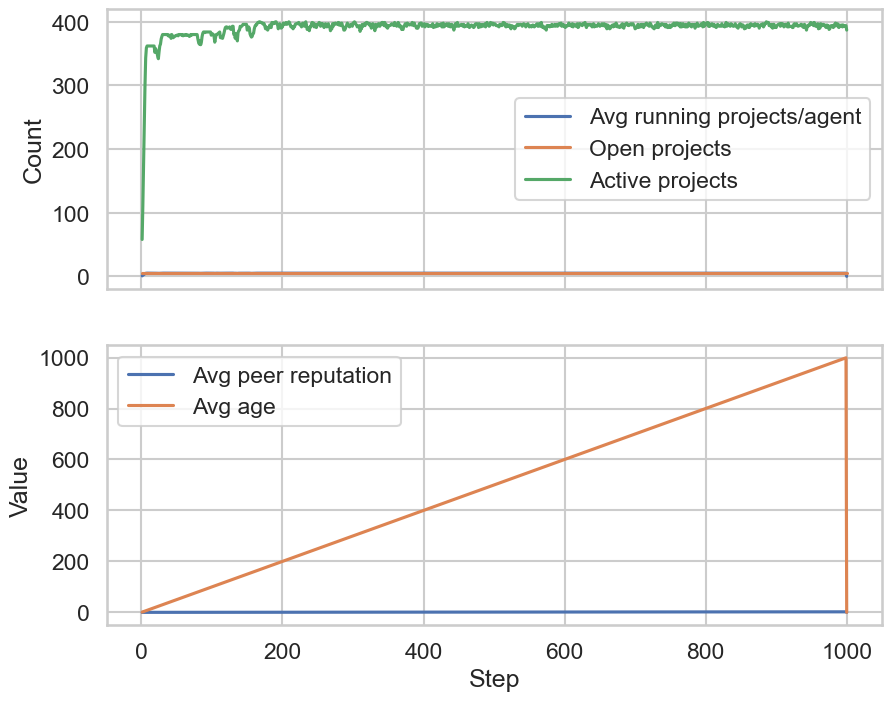

In [8]:
# 5) Environment-level aggregates from observations
cols = [
    "observation_aggregates.avg_running_projects_per_agent",
    "observation_aggregates.open_projects_count",
    "observation_aggregates.active_projects_count",
    "observation_aggregates.avg_peer_reputation",
    "observation_aggregates.avg_age",
]
subset = df[["step"] + [c for c in cols if c in df.columns]]

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
if "observation_aggregates.avg_running_projects_per_agent" in subset:
    axs[0].plot(subset["step"], subset["observation_aggregates.avg_running_projects_per_agent"], label="Avg running projects/agent")
if "observation_aggregates.open_projects_count" in subset:
    axs[0].plot(subset["step"], subset["observation_aggregates.open_projects_count"], label="Open projects")
if "observation_aggregates.active_projects_count" in subset:
    axs[0].plot(subset["step"], subset["observation_aggregates.active_projects_count"], label="Active projects")
axs[0].legend(); axs[0].set_ylabel("Count")

if "observation_aggregates.avg_peer_reputation" in subset:
    axs[1].plot(subset["step"], subset["observation_aggregates.avg_peer_reputation"], label="Avg peer reputation")
if "observation_aggregates.avg_age" in subset:
    axs[1].plot(subset["step"], subset["observation_aggregates.avg_age"], label="Avg age")
axs[1].legend(); axs[1].set_xlabel("Step"); axs[1].set_ylabel("Value")
plt.show()

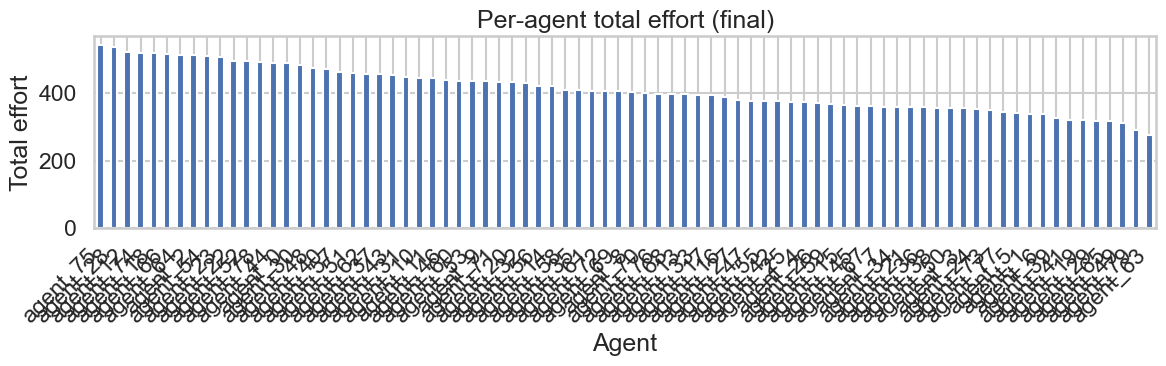

In [9]:
# 6) Per-agent effort (final snapshot)
with open(final_summary_path) as f:
    final_summary = json.load(f)

per_agent = pd.Series(final_summary.get("per_agent_total_effort", {}), name="total_effort").sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 4))
per_agent.plot(kind="bar", ax=ax)
ax.set_title("Per-agent total effort (final)")
ax.set_xlabel("Agent")
ax.set_ylabel("Total effort")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
# 7) Quick table of key final stats
pd.DataFrame({
    "finished_projects": [final_summary["finished_projects"]],
    "total_effort": [final_summary["total_effort"]],
    "avg_effort_per_step": [final_summary["avg_effort_per_step"]],
    "total_rewards_distributed": [final_summary["total_rewards_distributed"]],
    "avg_reward_per_step": [final_summary["avg_reward_per_step"]],
    "avg_running_projects_per_agent": [final_summary["observation_aggregates"].get("avg_running_projects_per_agent", np.nan)],
    "open_projects_count": [final_summary["observation_aggregates"].get("open_projects_count", np.nan)],
    "active_projects_count": [final_summary["observation_aggregates"].get("active_projects_count", np.nan)],
})

,finished_projects,total_effort,avg_effort_per_step,total_rewards_distributed,avg_reward_per_step,avg_running_projects_per_agent,open_projects_count,active_projects_count
0,4465,32902.26194,32.902262,178.022827,0.178023,0.0,6.0,387.0


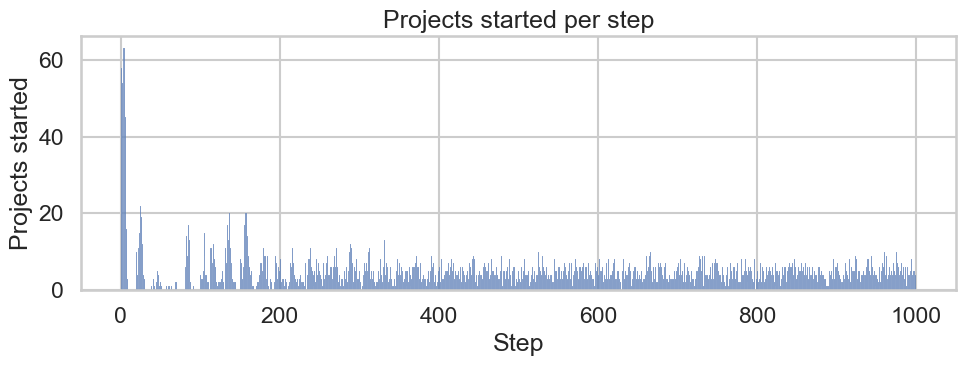

In [11]:
# 8) Histogram of projects started per step
# Re-read JSONL to avoid prior mutations of `rows`
rows2 = []
with open(jsonl_path) as f:
    for line in f:
        line = line.strip()
        if line:
            rows2.append(json.loads(line))

# Determine first-seen step for each project (start step)
seen_projects = set()
project_start_steps = []
for rec in rows2:
    step = rec["steps"]
    team_sizes_map = rec.get("observation_aggregates", {}).get("project_team_sizes", {})
    for project_id, size in team_sizes_map.items():
        if project_id not in seen_projects and size and size > 0:
            seen_projects.add(project_id)
            project_start_steps.append(step)

starts_df = pd.DataFrame({"start_step": project_start_steps})

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data=starts_df, x="start_step", bins=df["step"].nunique(), discrete=True, ax=ax)
ax.set_xlabel("Step")
ax.set_ylabel("Projects started")
ax.set_title("Projects started per step")
plt.tight_layout()
plt.show()


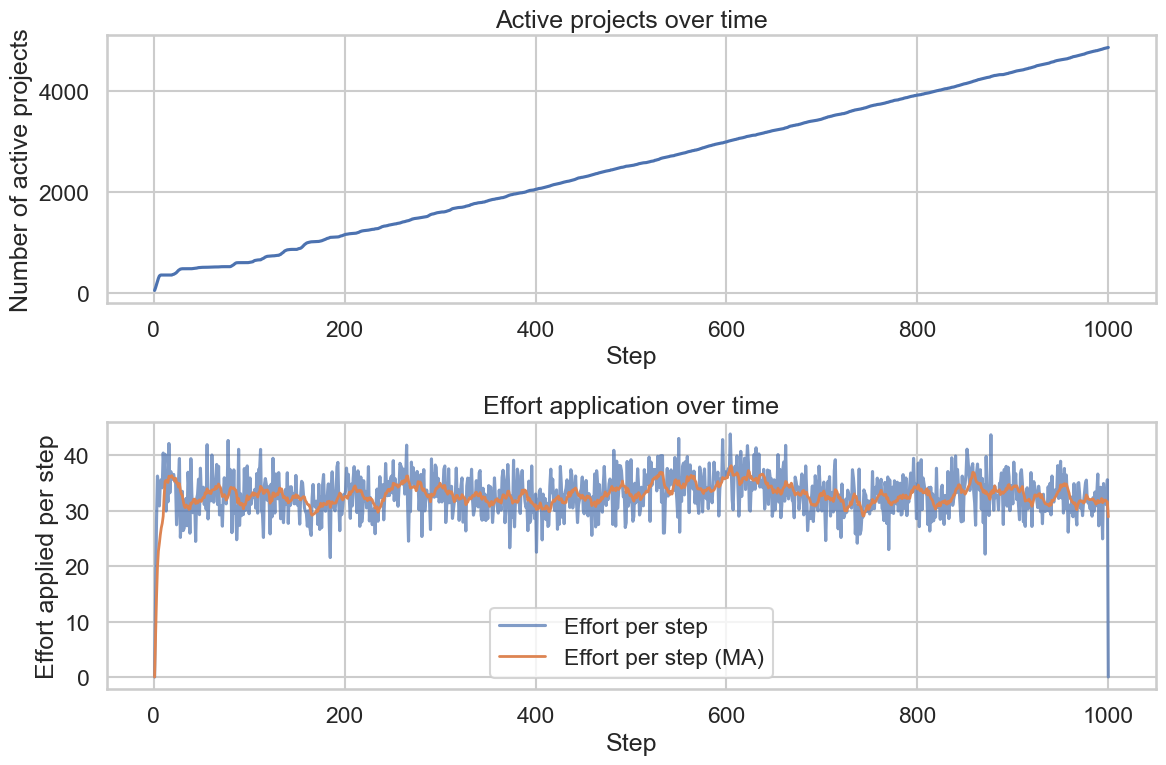

Effort delta at step 150: 31.90908181564737
Active projects at step 150: 868

Environment parameters:
- max_timesteps: 1000
- max_rewardless_steps: 24
- max_projects_per_agent: 6

No sudden drops in active projects detected


In [12]:
# 9) Analyze effort action patterns and agent truncations
# Check if agents are being truncated and losing their active projects

# Count active projects per step
active_projects_per_step = []
for rec in rows2:
    step = rec["steps"]
    team_sizes_map = rec.get("observation_aggregates", {}).get("project_team_sizes", {})
    active_count = sum(1 for size in team_sizes_map.values() if size > 0)
    active_projects_per_step.append({"step": step, "active_projects": active_count})

active_df = pd.DataFrame(active_projects_per_step)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot active projects over time
ax1.plot(active_df["step"], active_df["active_projects"], label="Active projects")
ax1.set_xlabel("Step")
ax1.set_ylabel("Number of active projects")
ax1.set_title("Active projects over time")
ax1.grid(True)

# Plot effort delta to see when effort stops being applied
ax2.plot(df["step"], df["effort_delta"], label="Effort per step", alpha=0.7)
ax2.plot(df["step"], df["effort_delta_ma"], label="Effort per step (MA)", linewidth=2)
ax2.set_xlabel("Step")
ax2.set_ylabel("Effort applied per step")
ax2.set_title("Effort application over time")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Check for patterns around step 150
print(f"Effort delta at step 150: {df[df['step'] == 150]['effort_delta'].iloc[0] if 150 in df['step'].values else 'N/A'}")
print(f"Active projects at step 150: {active_df[active_df['step'] == 150]['active_projects'].iloc[0] if 150 in active_df['step'].values else 'N/A'}")

# Check if agents are hitting truncation limits
print(f"\nEnvironment parameters:")
print(f"- max_timesteps: 1000")
print(f"- max_rewardless_steps: 24")
print(f"- max_projects_per_agent: 6")

# Look for sudden drops in active projects
active_df["active_projects_diff"] = active_df["active_projects"].diff()
sudden_drops = active_df[active_df["active_projects_diff"] < -2]
if not sudden_drops.empty:
    print(f"\nSudden drops in active projects at steps: {sudden_drops['step'].tolist()}")
else:
    print(f"\nNo sudden drops in active projects detected")

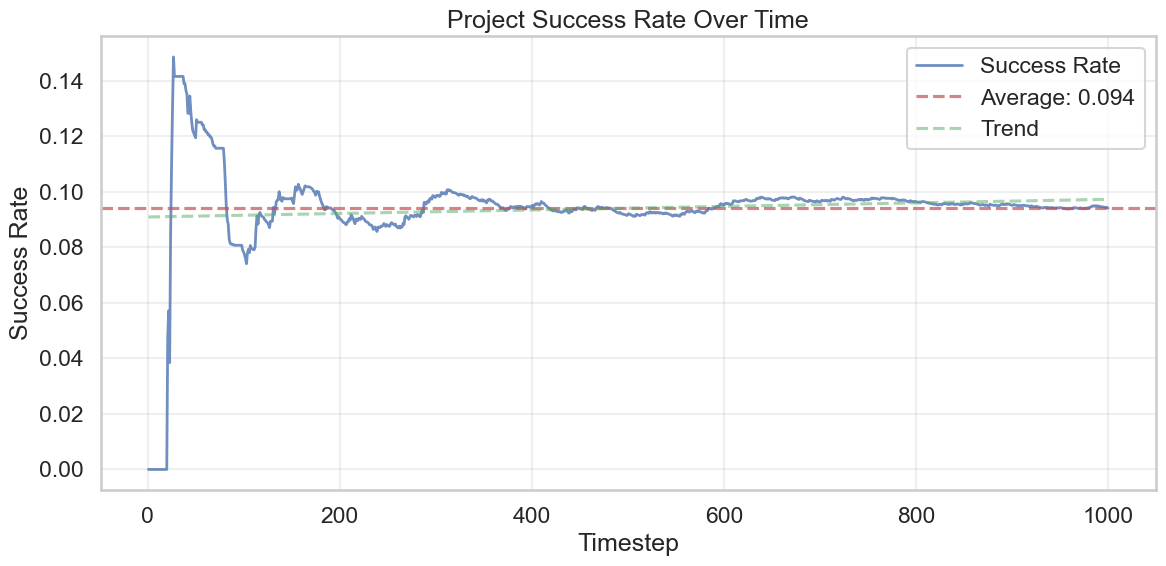

Average Success Rate: 0.094
Final Success Rate: 0.094
Min Success Rate: 0.000
Max Success Rate: 0.149


In [16]:
stats_data = rows
# Extract success rate data
timesteps = [s.get('steps', i) for i, s in enumerate(stats_data)]
success_rates = [s.get('success_rate', 0.0) for s in stats_data]

# Create success rate plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(timesteps, success_rates, 'b-', linewidth=2, alpha=0.8, label='Success Rate')

# Add average line
avg_success = np.mean(success_rates)
ax.axhline(y=avg_success, color='r', linestyle='--', alpha=0.7, 
           label=f'Average: {avg_success:.3f}')

# Add trend line
z = np.polyfit(timesteps, success_rates, 1)
p = np.poly1d(z)
ax.plot(timesteps, p(timesteps), "g--", alpha=0.5, label='Trend')

ax.set_xlabel('Timestep')
ax.set_ylabel('Success Rate')
ax.set_title('Project Success Rate Over Time')
ax.grid(True, alpha=0.3)
ax.legend()
# ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Average Success Rate: {avg_success:.3f}")
print(f"Final Success Rate: {success_rates[-1]:.3f}")
print(f"Min Success Rate: {min(success_rates):.3f}")
print(f"Max Success Rate: {max(success_rates):.3f}")

In [17]:
# Check if peer group data exists
if 'peer_group_sizes' in stats_data[0]:
    # Extract peer group size data
    peer_group_data = [s.get('peer_group_sizes', []) for s in stats_data]
    max_groups = max(len(sizes) for sizes in peer_group_data if sizes)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot each peer group
    for group_idx in range(max_groups):
        group_sizes = []
        for step_data in peer_group_data:
            if step_data and group_idx < len(step_data):
                group_sizes.append(step_data[group_idx])
            else:
                group_sizes.append(0)
        
        ax.plot(timesteps, group_sizes, 
               label=f'Peer Group {group_idx + 1}', 
               alpha=0.8, linewidth=2, marker='o', markersize=3)
    
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Peer Group Size')
    ax.set_title('Peer Group Sizes Over Time')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print peer group statistics
    for group_idx in range(max_groups):
        group_sizes = [s.get('peer_group_sizes', [])[group_idx] 
                      if s.get('peer_group_sizes') and group_idx < len(s.get('peer_group_sizes', [])) 
                      else 0 for s in stats_data]
        print(f"Peer Group {group_idx + 1}: Avg={np.mean(group_sizes):.1f}, "
              f"Final={group_sizes[-1]}, Max={max(group_sizes)}")
else:
    print("No peer group size data found in stats")

No peer group size data found in stats


In [1]:
# Simple Policy Simulation Visualization
import matplotlib.pyplot as plt
import numpy as np
import json
import glob

# Load the policy simulation results
results_files = glob.glob("results_*.json")
if not results_files:
    results_files = ["policy_simulation_results.jsonl"]

results = {}
for file in results_files:
    with open(file, 'r') as f:
        data = json.load(f)
        config_name = file.replace("results_", "").replace(".json", "").replace("_", " ").title()
        results[config_name] = data

print(f"Loaded {len(results)} results")

Loaded 4 results


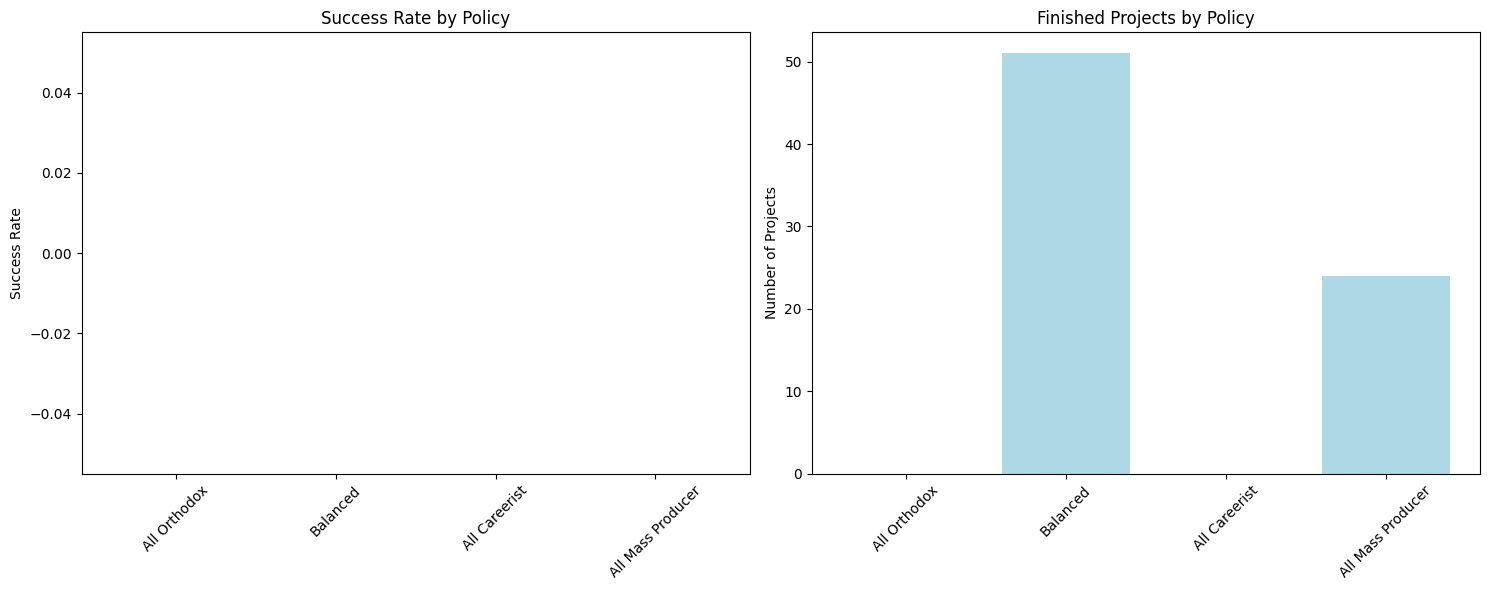

In [2]:
# Plot 1: Policy Performance Comparison
configs = list(results.keys())
success_rates = [results[c]["final_stats"]["success_rate"] for c in configs]
finished_projects = [results[c]["final_stats"]["finished_projects"] for c in configs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(configs, success_rates, color='lightgreen')
ax1.set_title('Success Rate by Policy')
ax1.set_ylabel('Success Rate')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(configs, finished_projects, color='lightblue')
ax2.set_title('Finished Projects by Policy')
ax2.set_ylabel('Number of Projects')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

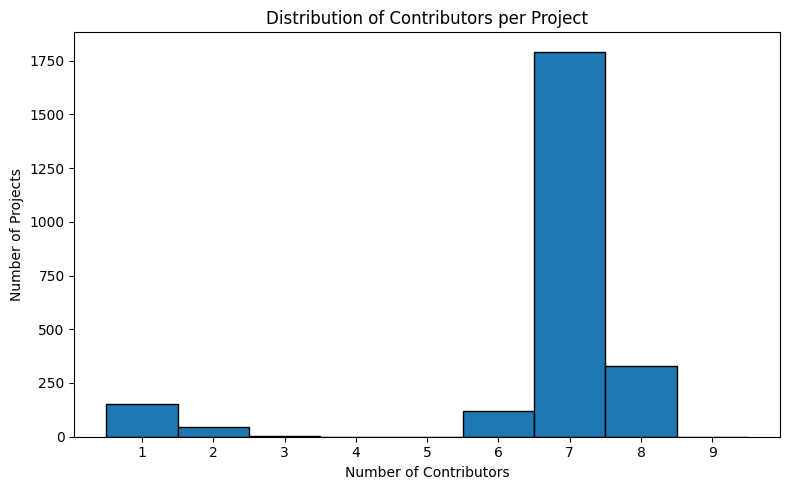

In [11]:
import json
import matplotlib.pyplot as plt

# Load projects list from JSON file
with open("../log/policy_sim_projects.json", "r") as f:
    projects = json.load(f)

# Extract project IDs and contributor counts
project_ids = [p["project_id"] for p in projects]
num_contributors = [len(p["contributors"]) for p in projects]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(num_contributors, bins=range(1, max(num_contributors) + 2), edgecolor="black", align="left")
plt.xlabel("Number of Contributors")
plt.ylabel("Number of Projects")
plt.title("Distribution of Contributors per Project")
plt.xticks(range(1, max(num_contributors) + 1))
plt.tight_layout()
plt.show()


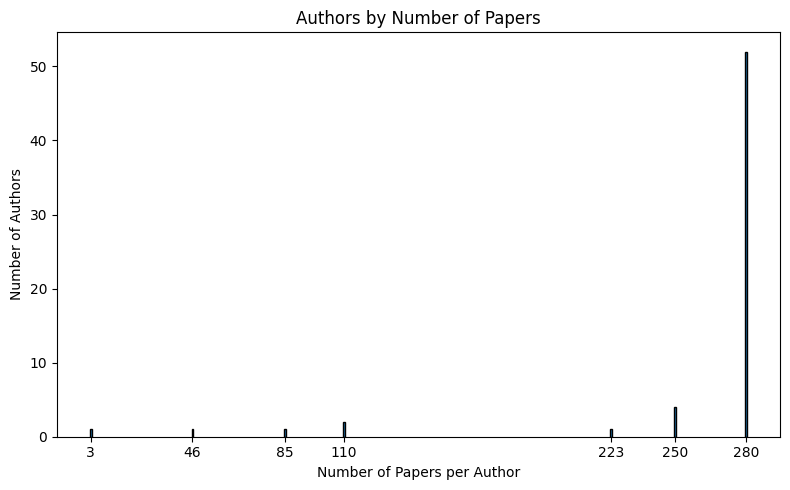

In [12]:
from collections import Counter

# Flatten all contributors into one list
all_contributors = []
for p in projects:
    all_contributors.extend(p["contributors"])

# Count number of projects per contributor
author_counts = Counter(all_contributors)

# Count how many authors fall into each "papers per author" category
papers_per_author = list(author_counts.values())
distribution = Counter(papers_per_author)

# Sort bins by number of papers
bins = sorted(distribution.keys())
authors_in_bins = [distribution[b] for b in bins]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(bins, authors_in_bins, width=0.8, edgecolor="black")
plt.xlabel("Number of Papers per Author")
plt.ylabel("Number of Authors")
plt.title("Authors by Number of Papers")
plt.xticks(bins)  # discrete ticks at bin centers
plt.tight_layout()
plt.show()


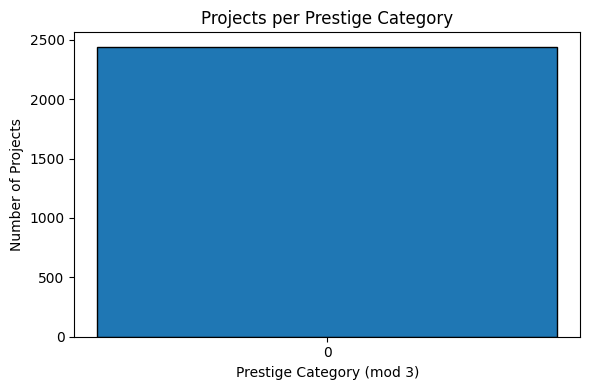

In [13]:
# Compute prestige category for each project
prestige_categories = [int(p["project_id"].split("-")[1]) % 3 for p in projects]

# Count projects per category
category_counts = Counter(prestige_categories)

# Sort categories for plotting
categories = sorted(category_counts.keys())
counts = [category_counts[c] for c in categories]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(categories, counts, width=0.6, edgecolor="black")
plt.xlabel("Prestige Category (mod 3)")
plt.ylabel("Number of Projects")
plt.title("Projects per Prestige Category")
plt.xticks(categories)
plt.tight_layout()
plt.show()

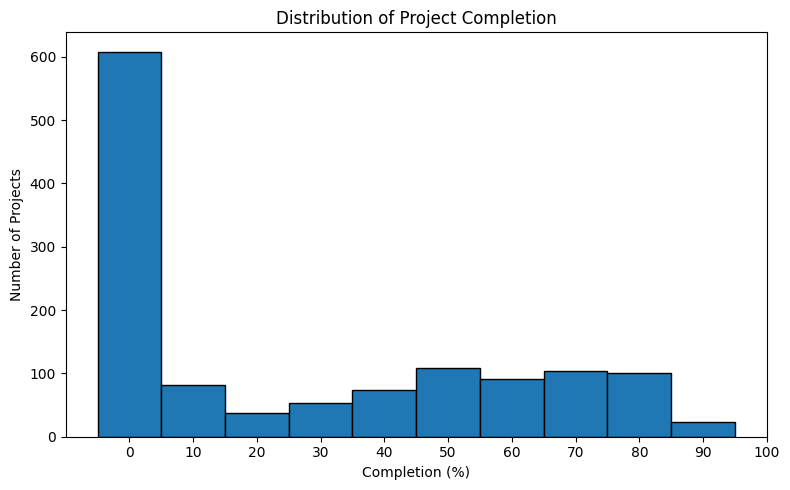

In [15]:

# Compute completion percentage per project
project_ids = [p["project_id"] for p in projects]
completion = [
    (p["current_effort"] / p["required_effort"]) * 100
    for p in projects
]

# Plot histogram with bins (0–100 in steps of 10)
plt.figure(figsize=(8, 5))
plt.hist(completion, bins=range(0, 110, 10), edgecolor="black", align="left")
plt.xlabel("Completion (%)")
plt.ylabel("Number of Projects")
plt.title("Distribution of Project Completion")
plt.xticks(range(0, 110, 10))
plt.tight_layout()
plt.show()


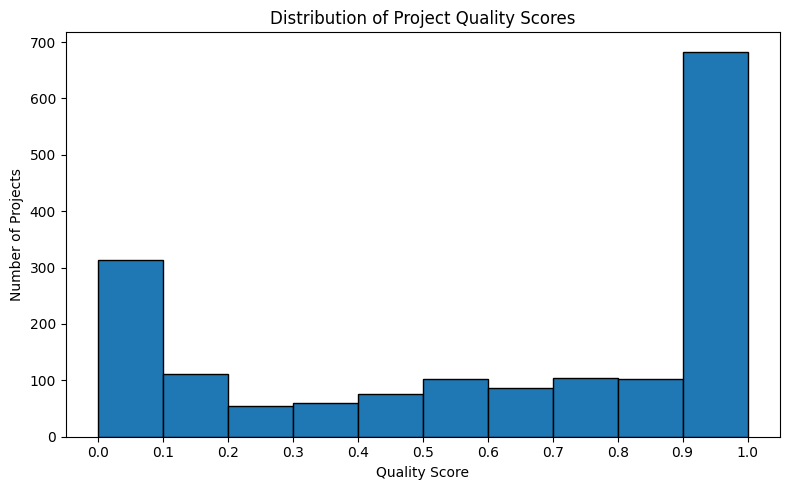

In [16]:
# Extract quality scores
quality_scores = [p["quality_score"] for p in projects]

# Plot histogram (bins of 0.1 from 0 to 1)
plt.figure(figsize=(8, 5))
plt.hist(quality_scores, bins=[i/10 for i in range(0, 11)], edgecolor="black", align="mid")
plt.xlabel("Quality Score")
plt.ylabel("Number of Projects")
plt.title("Distribution of Project Quality Scores")
plt.xticks([i/10 for i in range(0, 11)])
plt.tight_layout()
plt.show()

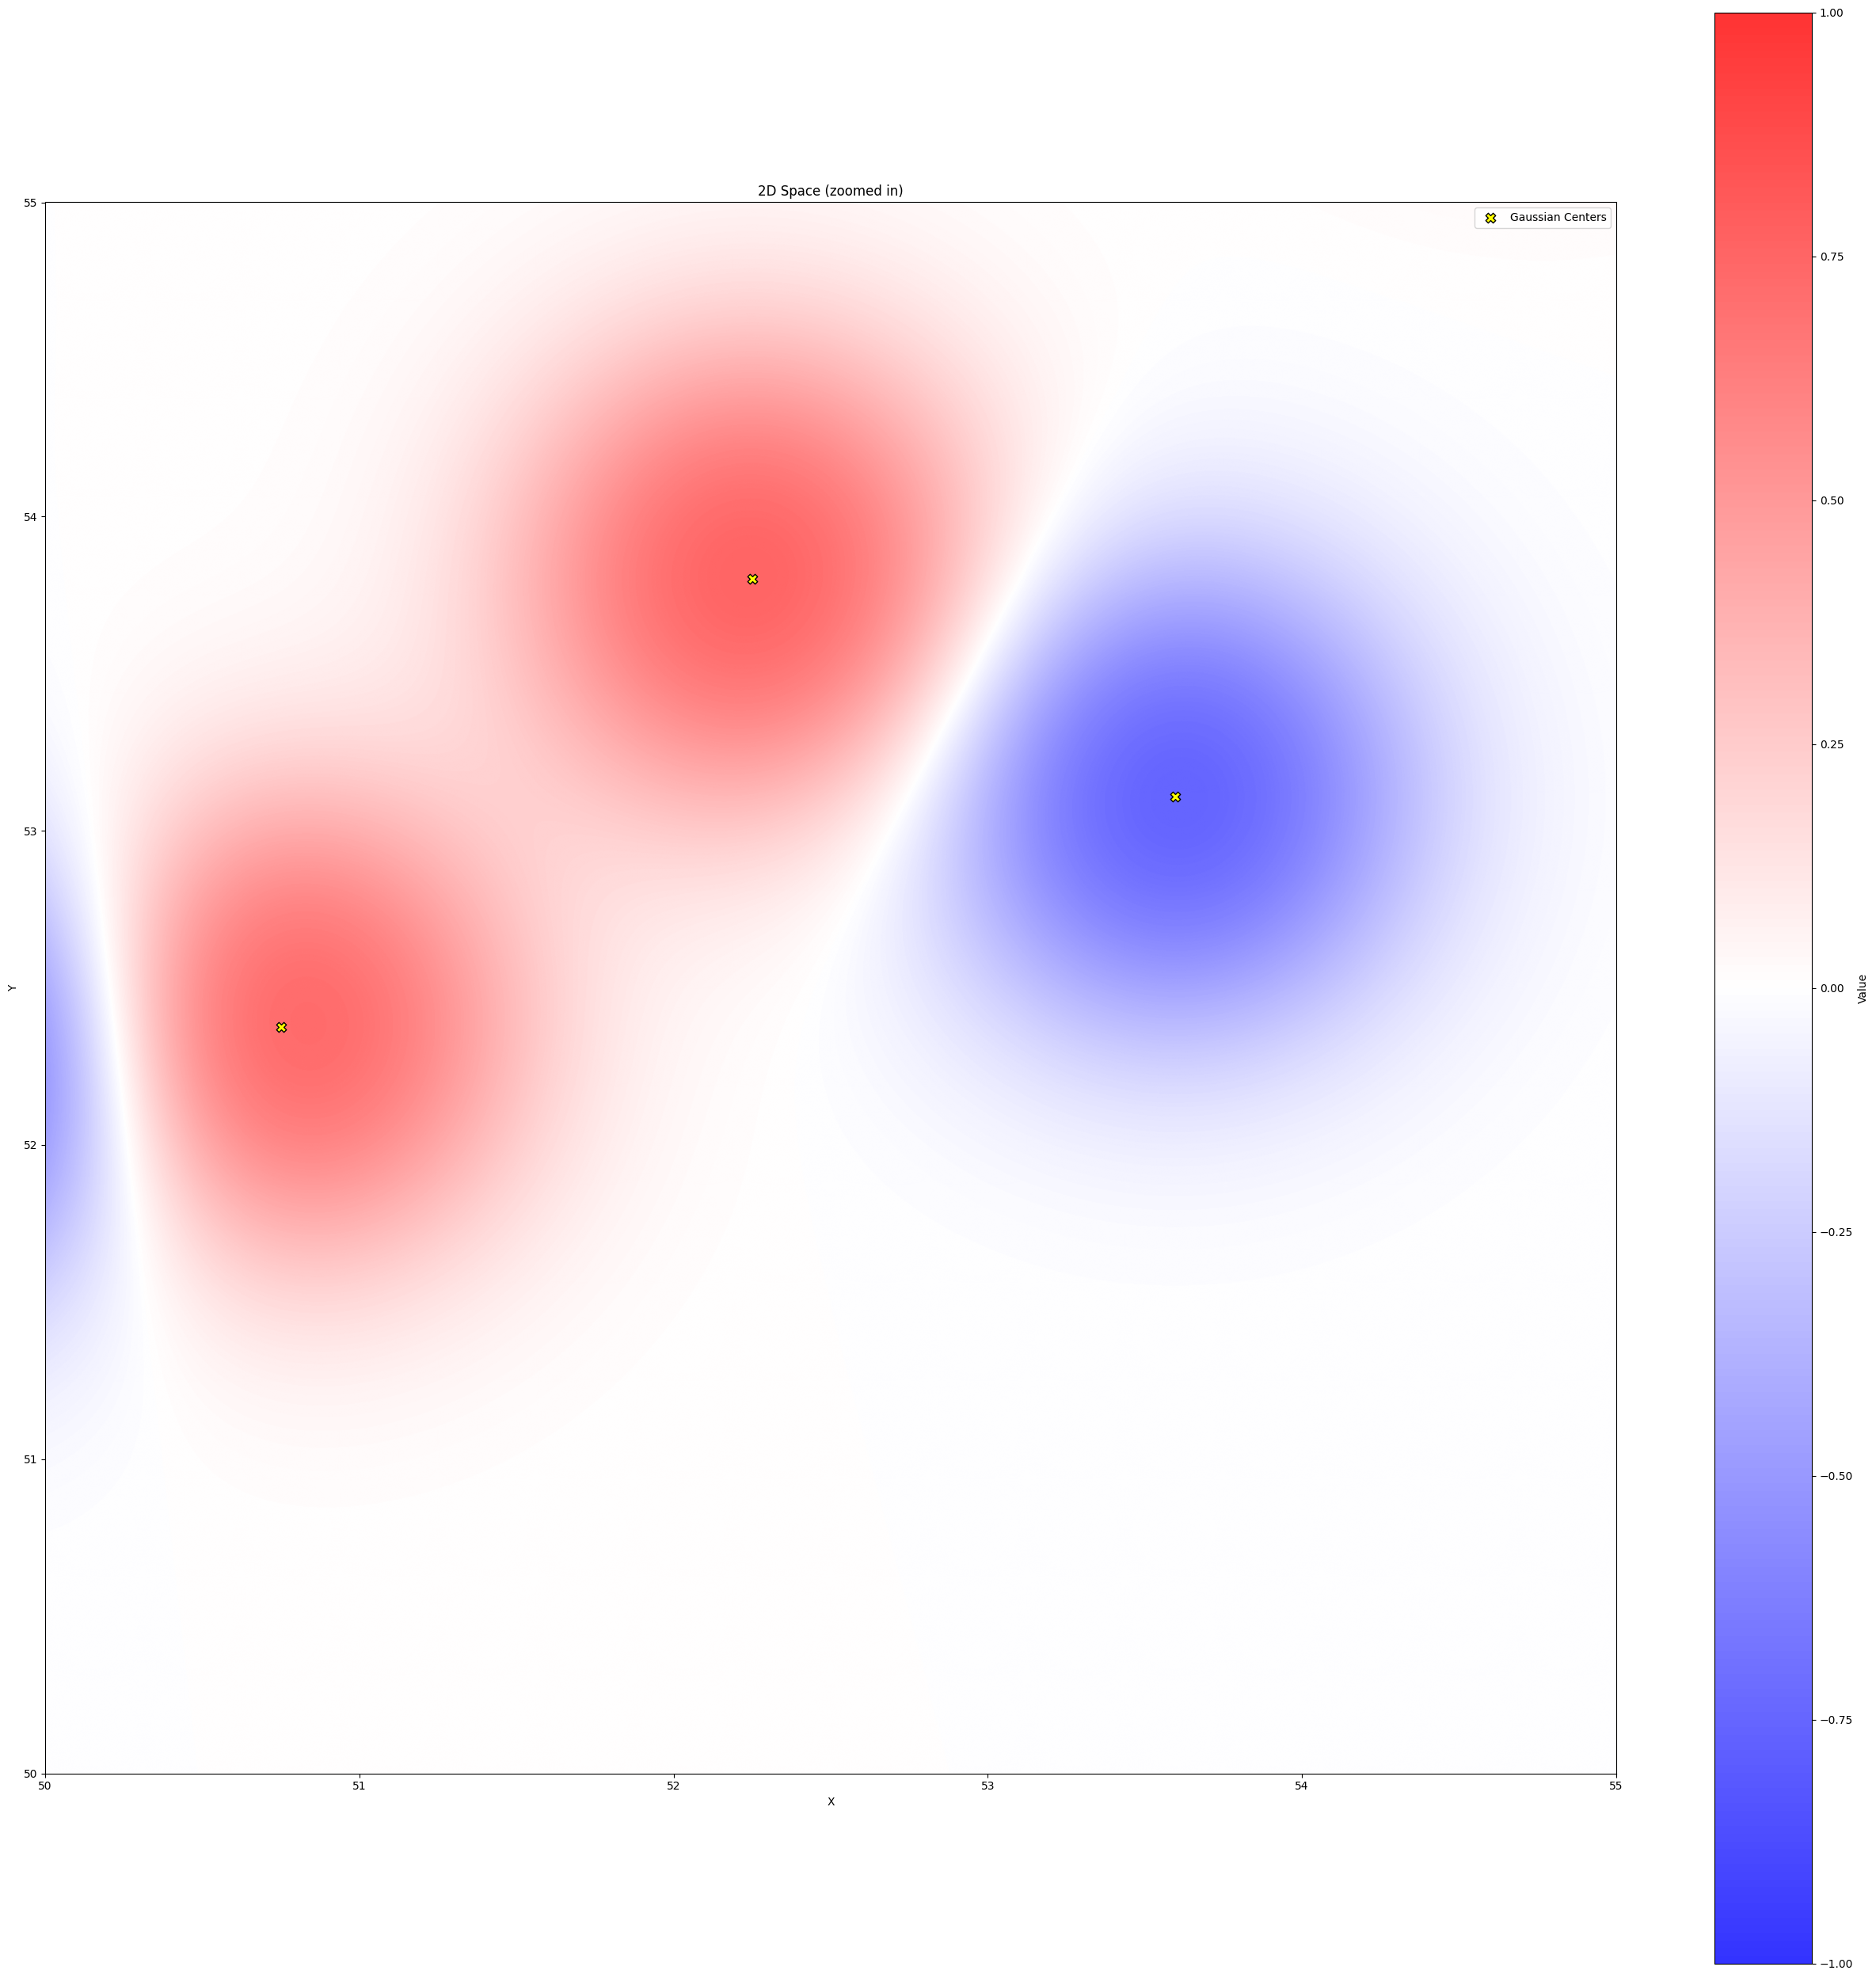

In [18]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

class Space2D:
    def __init__(self, xlim=(0, 100), ylim=(0, 100)):
        self.xlim = xlim
        self.ylim = ylim
        self.areas = []  # list of (x0, y0, sigma, value)
        self.bias = (0.0, 0.0, 0.0)  # optional bias plane coefficients (a, b, c)

    def random_point(self):
        x = random.uniform(*self.xlim)
        y = random.uniform(*self.ylim)
        return (x, y)

    def add_gaussian_area(self, x0, y0, sigma, value):
        """
        Define a Gaussian region centered at (x0,y0) with std=sigma and value scaling.
        """
        self.areas.append((x0, y0, sigma, value))

    def distance(self, p1, p2):
        """
        Compute Euclidean distance between two points p1=(x1,y1) and p2=(x2,y2).
        """
        x1, y1 = p1
        x2, y2 = p2
        return math.hypot(x2 - x1, y2 - y1)
    
    def set_bias_plane(self, a=0.0, b=0.0, c=0.0):
        """
        Set a global bias plane: a*x + b*y + c
        """
        self.bias = (a, b, c)

    def value_at(self, x, y):
        """
        Return the weighted sum of Gaussian values at a point (x,y),
        plus optional bias plane, squashed with tanh to keep values bounded.
        """
        a, b, c = self.bias
        val = a * x + b * y + c
        for (x0, y0, sigma, v) in self.areas:
            exponent = -((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)
            val += v * math.exp(exponent)
        return math.tanh(val)

    def points_within_radius(self, x, y, radius, num_points=100):
        """
        Return a set of random points sampled uniformly within radius of (x,y).
        """
        points = []
        while len(points) < num_points:
            angle = random.uniform(0, 2 * math.pi)
            r = radius * math.sqrt(random.random())  # uniform distribution in circle
            px = x + r * math.cos(angle)
            py = y + r * math.sin(angle)
            if self.xlim[0] <= px <= self.xlim[1] and self.ylim[0] <= py <= self.ylim[1]:
                points.append((px, py))
        return points

    def random_points_in_radius(self, x, y, radius, num_points=None):
        """
        Return a random set of points within the radius of (x,y).
        If num_points is None, a random number of points is selected.
        """
        if num_points is None:
            num_points = random.randint(1, 50)  # pick up to 50 random points by default

        return self.points_within_radius(x, y, radius, num_points=num_points)

    def visualize(self, resolution=200, sampled_points=None, bounds=None):
        """
        Visualize the space as a heatmap.
        bounds = (xmin, xmax, ymin, ymax) to zoom in on a subarea.
        """
        if bounds is None:
            xmin, xmax = self.xlim
            ymin, ymax = self.ylim
        else:
            xmin, xmax, ymin, ymax = bounds

        x = np.linspace(xmin, xmax, resolution)
        y = np.linspace(ymin, ymax, resolution)
        X, Y = np.meshgrid(x, y)

        # Same calculation for Z as before...
        a, b, c = self.bias
        Z = a * X + b * Y + c
        for (x0, y0, sigma, v) in self.areas:
            Z += v * np.exp(-((X - x0) ** 2 + (Y - y0) ** 2) / (2 * sigma ** 2))
        Z = np.tanh(Z)

        plt.figure(figsize=(32, 32))
        plt.imshow(Z, extent=(xmin, xmax, ymin, ymax),
                origin='lower', cmap='bwr', vmin=-1.0, vmax=1.0, alpha=0.8)
        plt.colorbar(label="Value")

        # Plot Gaussian centers that fall inside the bounds
        if self.areas:
            cx, cy = zip(*[(x0, y0) for (x0, y0, _, _) in self.areas
                        if xmin <= x0 <= xmax and ymin <= y0 <= ymax])
            if cx:
                plt.scatter(cx, cy, c='yellow', s=80, edgecolors='black', marker='X', label='Gaussian Centers')

        # Plot sampled points if provided
        if sampled_points is not None:
            px, py = zip(*[(px, py) for (px, py) in sampled_points
                        if xmin <= px <= xmax and ymin <= py <= ymax])
            if px:
                plt.scatter(px, py, c='black', s=20, edgecolors='white', label='Sampled Points')

        plt.legend()
        plt.title("2D Space (zoomed in)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()



if __name__ == "__main__":
    # Initialize space
    space = Space2D(xlim=(0, 100), ylim=(0, 100))

    # Add Gaussian areas
    for _ in range(100):
        space.add_gaussian_area(*space.random_point(), sigma=0.5, value=1.0)
        space.add_gaussian_area(*space.random_point(), sigma=0.5, value=-1.0)

    

    # Pick a random point and sample around it
    center = space.random_point()
    sampled_pts = space.random_points_in_radius(center[0], center[1], radius=15, num_points=20)

    # Visualize
    space.visualize(resolution=2000, bounds=(50, 55, 50, 55))


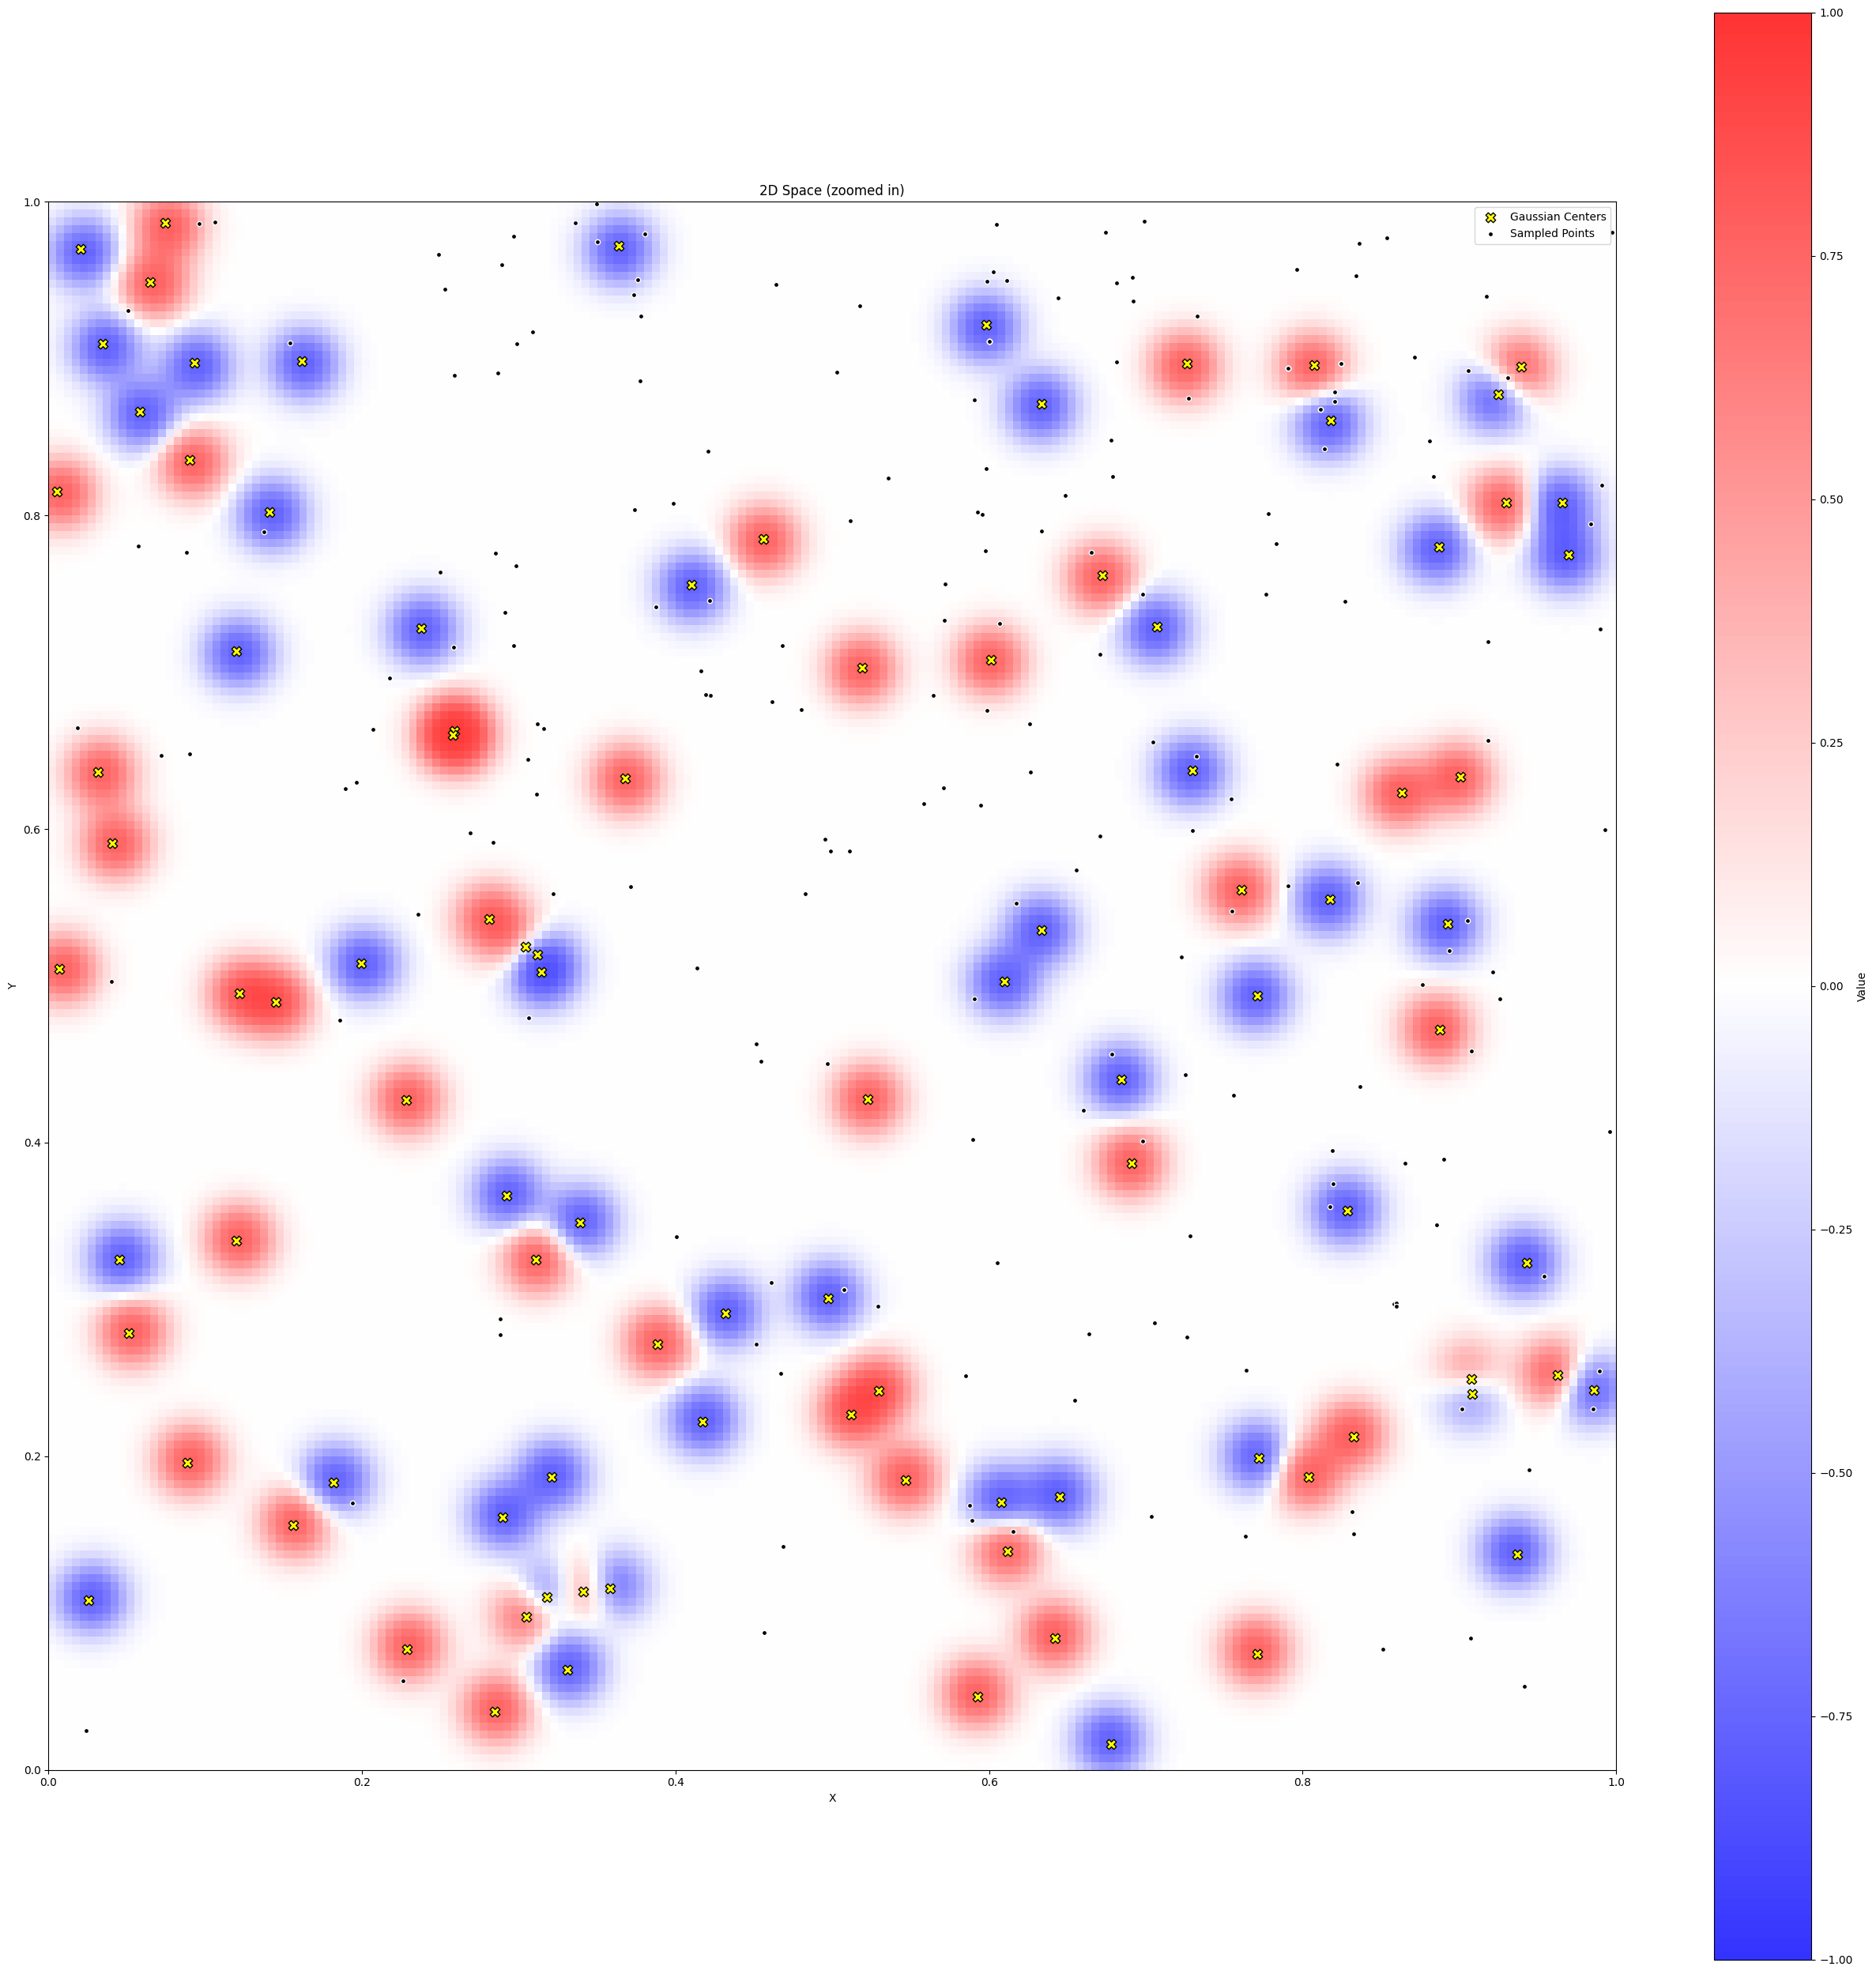

In [5]:
from env.area import Area
import json
area = Area.load("../log/debug_sim_actions.pickle")
# Load projects list from JSON file
with open("../log/debug_sim_projects.json", "r") as f:
    projects = json.load(f)

area.visualize(sampled_points=[p["kene"] for p in projects])

In [7]:
with open("/Users/chrible/Downloads/45602.json", "r") as f:
    text = json.load(f)

In [11]:
len(text["page_chars"].keys())

348